(chap_point_operations)=
# Point operations

:::{admonition} Chapter outline
:class: tip

* **Point operations** are mathematical operations applied to individual pixel values
* Point operations can be performed using a **single image**, an **image and a constant**, or **two images of the same size**
* Some **nonlinear** point operations change the relationships between pixels in a way that can be useful to enhance contrast -- but should be used with caution
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

A step used to process an image in some way can be called an **operation**.

The simplest operations are **point operations**, which act on individual pixels.
Point operations change each pixel in a way that depends upon its own value, but not upon where it is in the image nor upon the values of other pixels.
This is in contrast to **neighborhood operations**, which calculate new pixel values based upon the values of pixels nearby.

While not immediately very glamorous, point operations often have indispensable roles in more interesting contexts -- and so it's essential to know how they are used, and what complications to look out for.


:::{admonition} Isn't modifying pixels bad?
:class: warning

Part I stressed repeatedly that modifying pixels is a bad thing.
Since image processing is all about changing pixel values, it's time to add a bit more nuance:

**Modifying pixel values is bad -- unless you have a good reason**.

A 'good reason' is something you can justify based upon the image data.
Something you could confidently include in a journal article describing how you analyzed your image, and convince a reviewer was sensible.

You should also make sure to apply the processing to a **duplicate** of the image, and keep the original file.
That way you can always return to the original data if you need to.
:::


## Point operations for single images

### Arithmetic

Pixel values are just numbers.
When we have numbers, we can do arithmetic.

It should therefore come as no surprise that we can take our pixel values and change them by adding, subtracting, multiplying or dividing by some other value.
These are the simplest point operations.

We encountered this idea earlier when we saw that multiplying our pixel values could [increase the brightness](sec_images_luts).
I argued that this was a *very bad thing* because it changes our data.
Our better alternative was to change the LUT instead.

Nevertheless, there are sometimes 'good reasons' to apply arithmetic to pixel values -- better than simply brightening the appearance.
Examples include:
* Subtracting a constant offset added by a microscope before quantifying intensities
  * See {ref}`chap_macro_simulating`
* Dividing by a constant so that you can convert bit-depth without clipping
  * See {ref}`chap_bit_depths`

**However**, we need to keep in mind that we're not dealing with abtract maths but rather bits and bytes.
Which makes the next question particularly important.

````{tab-set}

```{tab-item} Question
Suppose you add a constant to every pixel in the image.
Why might subtracting the same constant from the result not give you back the image you started with?
```

```{tab-item} Answer
If you add a constant that pushes pixel values outside the range supported by the bit-depth (e.g. 0–255 for 8-bit), then the result cannot fit in the image.
It's likely to be clipped to the closest possible value instead.
Subtracting the constant again does not restore the original value.

For example: 200 *(original value)* + 100 *(constant)* &rarr; 255 *(closest valid value)*. <br/>
But then 255 - 100 &rarr; 155.
```

````

Based upon this, an important tip for image processing is:

:::{admonition} Convert integer images to floating point before manipulating pixels
:class: tip

A 32-bit (or even 64-bit) floating point image is much less likely to suffer errors due to clipping and rounding.
Therefore the first step of any image processing is often to convert the image to a floating point format.

See {ref}`chap_bit_depths` for details.
:::

(sec_points_inversion)=
### Image inversion

Inverting an image effectively involves 'flipping' the intensities: making the higher values lower, and the lower values higher.

In the case of 8-bit images, inverted pixel values can be easily computed simply by subtracting the original values from the maximum possible -- i.e. from 255.

Why is inversion useful?

Suppose you have a good strategy designed to detect bright structures, but it doesn't work for you because your images contain dark structures.
If you invert your images first, then the structures become bright -- and your detection strategy might now succeed.

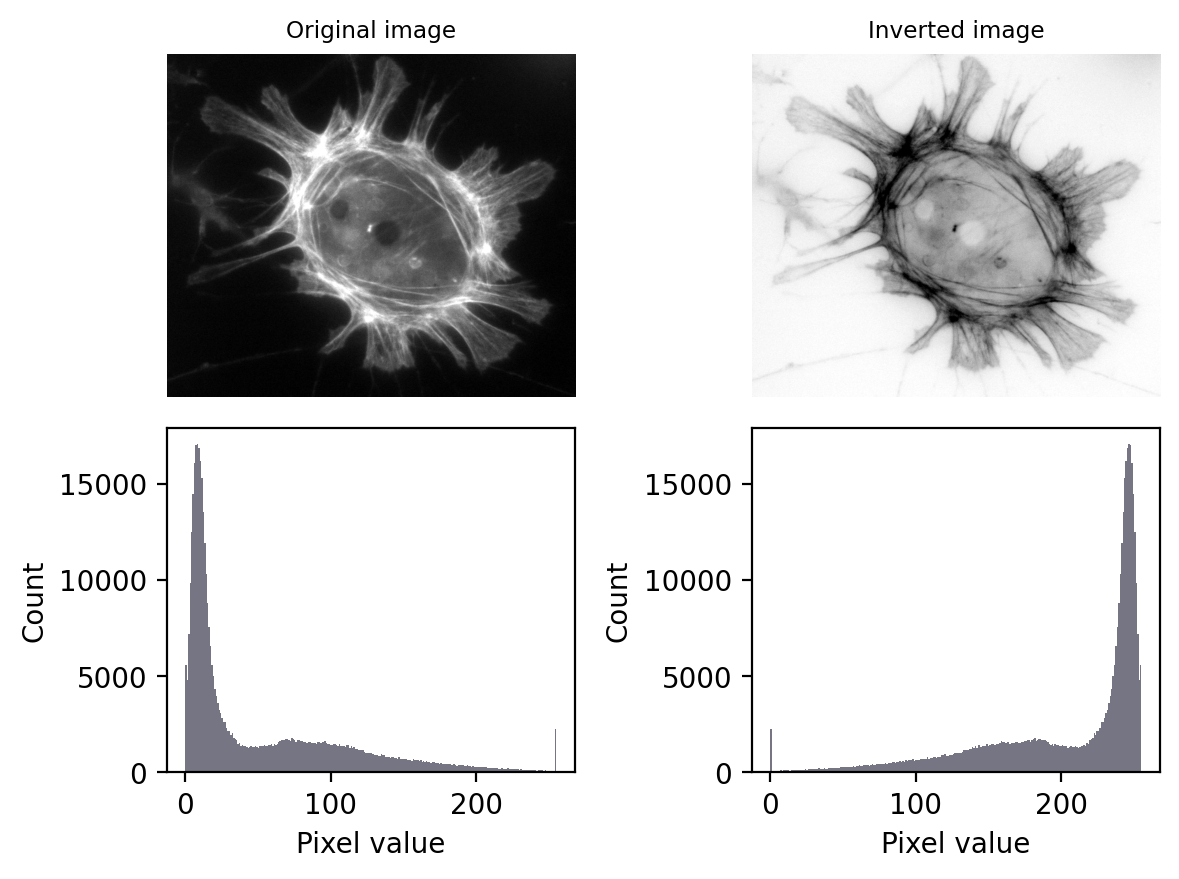

In [2]:
"""
Comparing inverting images and colormaps.
"""

from matplotlib import colormaps

fig = create_figure(figsize=(6, 4.5))

im = load_image('sunny_cell.tif')
lut = colormaps['gray']

# Ensure the image is 8-bit with sensible contrast
im = im.astype(np.float32)
im = im - np.percentile(im, 0.5)
im = im / np.percentile(im, 99.5) * 255
im = np.clip(im, 0, 255)
im = im.astype(np.uint8)

# Plot main image
show_image(im, cmap=lut, title='Original image', pos=221)

# Plot inverted image
show_image(255 - im, title='Inverted image', cmap=lut, pos=222)

# Plot main image with inverted LUT
show_histogram(im, pos=223)

# Plot inverted image
show_histogram(255 - im, pos=224)

plt.tight_layout()

glue_fig("fig_points_invert", fig)

```{glue:figure} fig_points_invert
---
align: center
name: fig-image_inversion
figwidth: 85%
---
The effect of image and LUT inversion. Note that each histogram appears to be a mirror image of the other. Also, the image is clipped (sorry).
```


:::{admonition} Defining the 'maximum' when inverting an image

Inverting an 8-bit (unsigned integer) image generally means subtracting all pixel values from 255, because 255 is the maximum supported by the image type and bit-depth.

The 'maximum' is not always defined in this way.
For a 32-bit or 64-bit image (either integer or floating point), the maximum possible value is *huge*, and using that would result in exceedingly large pixel values.
Therefore the 'maximum' is usually defined in some other way rather than based on the image type, such as by taking the maximum pixel value found within the image.

Because I don't like letting the software decide what maximum to use, I often cheat: I multiply the pixels by -1 (ensuring the image is floating point).
This retains the key properties of image inversion: it flips the high and low values, while retaining all the relative diffences between values.
:::



### Nonlinear contrast enhancement

With arithmetic operations we change the pixel values, usefully or otherwise, but (assuming we have not clipped our image in the process) we have done so in a **linear** way.
At most it would take another multiplication and/or addition to get us back to where we were.
Because a similar relationship between pixel values exists, we could also adjust the brightness and contrast LUT so that it does not *look* like we have done anything at all.

**Nonlinear** point operations differ in that they affect relative values differently depending upon what they were in the first place.
These are particularly useful for contrast enhancement.

When we changed the brightness and contrast in {ref}`sec_images_luts`, we were making linear adjustments.
For a grayscale LUT, this meant we chose the pixel value to display as black and the pixel value to display as white, with each value in between mapped to a shade of gray along a straight line ({numref}`fig-nonlinear_contrast`A).

We could optionally use a nonlinear mapping values between values and shades of gray, but most software doesn't make it straightforward to change LUTs in sufficiently complicated ways.
An easier approach is to duplicate the image and apply any non-linear adjustments to the pixel values themselves, and then map them to shades of gray in the usual (linear) way.

Common nonlinear transforms are to take the logarithm of the pixel value ({numref}`fig-nonlinear_contrast`B), or replace each value $p$ with $p^\gamma$ where $\gamma$ is the *gamma* parameter that can be adjusted depending upon the desired outcome ({numref}`fig-nonlinear_contrast`B-D).

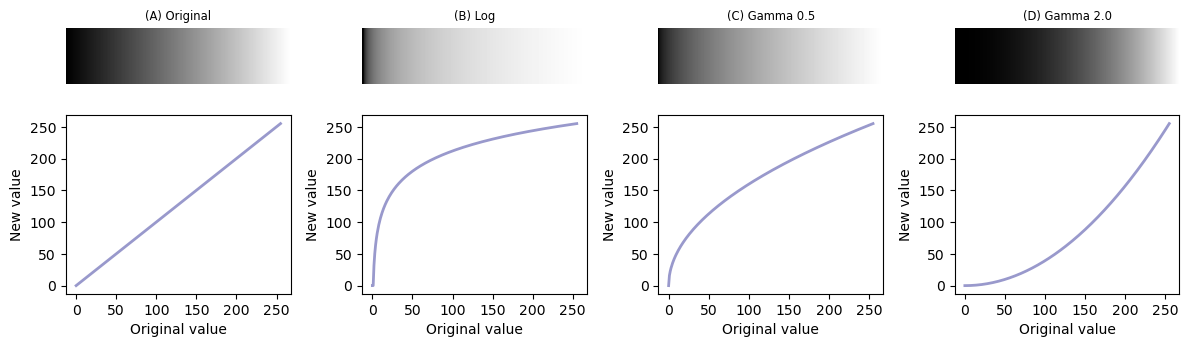

In [3]:
"""
Visualizing non-linear transforms and their impact on a ramp profile plot.
"""

fig = plt.figure(figsize=(12, 4))

# See ImageJ implementation at
# https://github.com/imagej/imagej1/blob/a0d335d1df4e4c0b4fc12c71ecfbb889d4c62e62/ij/process/ImageProcessor.java#L953

# Create a linear ramp of pixel values from 0-255
# This simulates an 8-bit ramp image
# (although we'll do the calculations in 32-bit)
ramp = np.tile(np.linspace(0, 255, num=256, dtype=np.float32), (64, 1))

plot_args = dict(xlabel='Original value', ylabel='New value', color=(0.6, 0.6, 0.8), linewidth=2)

# Show main plot (linear ramp)
show_image(ramp, cmap=lut, title='(A) Original', pos=241)
show_plot(ramp[0, :], pos=245, **plot_args)
plt.xticks(np.arange(0, 255, 50))

# Apply log transform
ramp_log = np.log(np.maximum(ramp, 1.0))*255/np.log(255)
show_image(ramp_log, cmap=lut, title='(B) Log', pos=242)
show_plot(ramp_log[0, :], pos=246, **plot_args)
plt.xticks(np.arange(0, 255, 50))

# Apply gamma transform (gamma = 0.5)
ramp_gamma05 = np.power(ramp/255, 0.5)*255
show_image(ramp_gamma05, cmap=lut, title='(C) Gamma 0.5', pos=243)
show_plot(ramp_gamma05[0, :], pos=247, **plot_args)
plt.xticks(np.arange(0, 255, 50))

# Apply gamma transform (gamma = 2.0)
ramp_gamma2 = np.power(ramp/255, 2)*255
show_image(ramp_gamma2, cmap=lut, title='(D) Gamma 2.0', pos=244)
show_plot(ramp_gamma2[0, :], pos=248, **plot_args)
plt.xticks(np.arange(0, 255, 50))

# plt.subplots_adjust(wspace=0.4)
plt.tight_layout()

glue_fig("fig_points_gamma_ramp", fig)

```{glue:figure} fig_points_gamma_ramp
---
align: center
name: fig-nonlinear_contrast
---
Nonlinear transforms applied to a simple 'ramp' image, consisting of linearly increasing pixel values.
Replacing each pixel with its log or gamma-adjusted value has the effect of compressing either the lower or higher intensities closer together to free up more gray levels for the others. Note that, here we assume an 8-bit input image and have incorporated some necessary rescaling for an 8-bit output (based on the approach used by ImageJ).
```

If all this sounds a dubious and awkward, be assured that it is: nonlinear transforms are best avoided whenever possible.

However, there is once scenario when they can really help: displaying an image with a **high dynamic range**, i.e. a big difference between the largest and smallest pixel values.

{numref}`fig-point_gamma_spooked` shows this in action.
Here, the pixel values associated with the main character are all quite high.
However, the values associated with the ghostly figure are all very low.
There are no linear contrast settings with a standard grayscale LUT that make it possible to see both figures with any detail simultaneously.
However, log or gamma transforms make this possible.

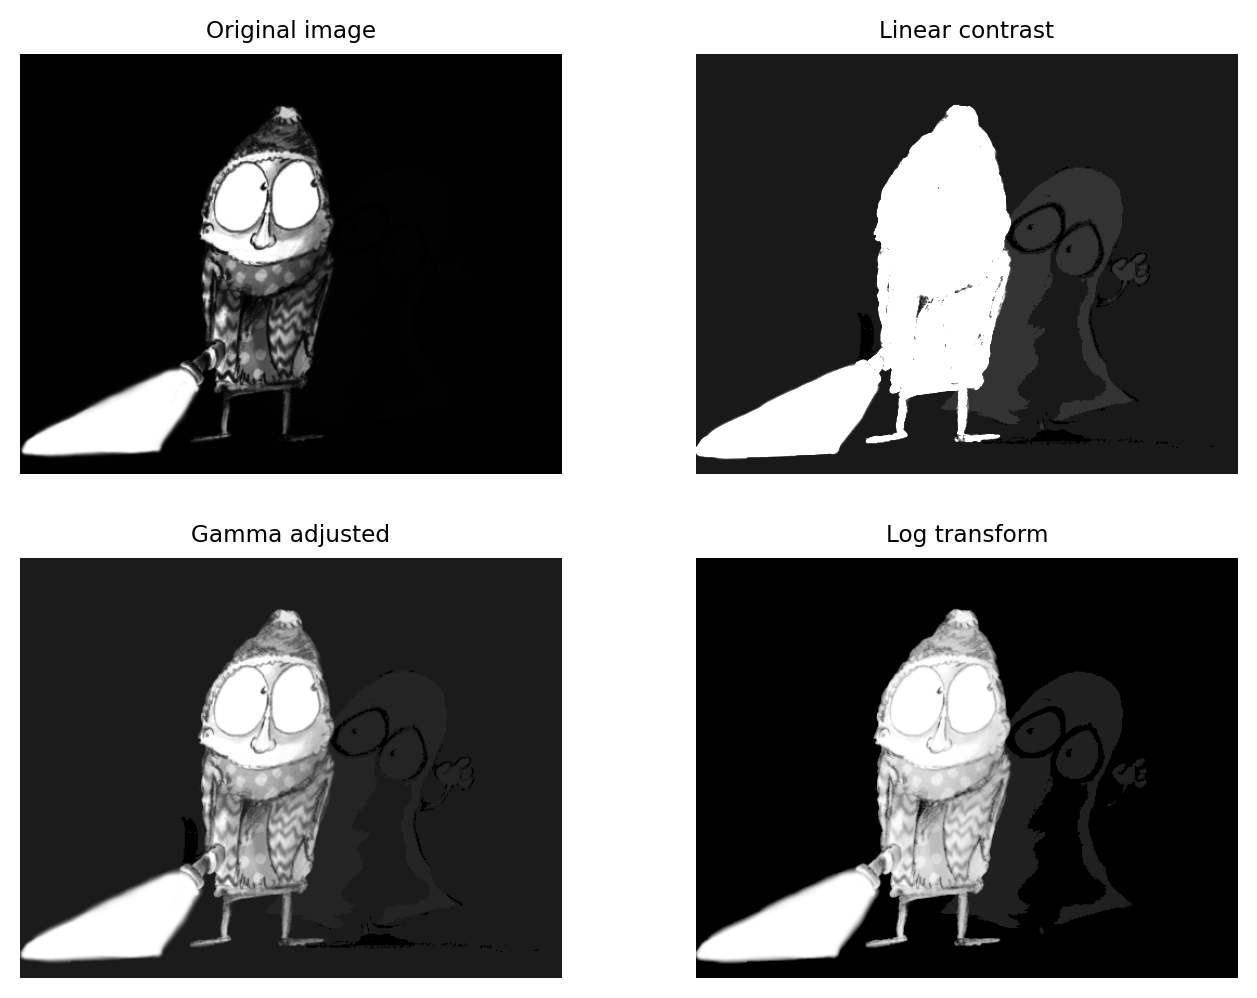

In [4]:
"""
Comparing transforms for an image with a high dynamic range.
"""

fig = create_figure(figsize=(8, 6))

# See ImageJ implementation at
# https://github.com/imagej/imagej1/blob/a0d335d1df4e4c0b4fc12c71ecfbb889d4c62e62/ij/process/ImageProcessor.java#L953

im = load_image('spooked.png')

# Show original image
show_image(im, vmin=0, vmax=255, title="Original image", pos=221)

# Set display range (linear contrast adjustment)
# (This has to be extremely stark to show the background details)
show_image(im, vmin=0, vmax=10, title="Linear contrast", pos=222)

# Apply gamma transform
im_gamma05 = np.power(im/255, 0.4)*255
show_image(im_gamma05, vmin=0, vmax=255, title="Gamma adjusted", pos=223)

# Apply log transform
im_log = np.log(np.maximum(im, 1.0))*255/np.log(255)
show_image(im_log, vmin=0, vmax=255, title="Log transform", pos=224)

glue_fig("fig_points_gamma", fig)

```{glue:figure} fig_points_gamma
---
align: center
name: fig-point_gamma_spooked
---
The application of nonlinear contrast enhancement to an image with a wide range of values.
*(Top row)* In the original image, it's not possible to see details in both the foreground and background simultaneously.
*(Bottom row)* Two examples of nonlinear techniques that make details visible throughout the image.
```

:::{admonition} Avoid image manipulation!
:class: warning

When creating figures for publication, changing the contrast in some linear manner is normally considered fine (assuming that it has not been done mischievously to make some inconvenient, research-undermining details impossible to discern).

**But if any nonlinear operations are used, these should always be noted in the figure legend!**

This is because, although nonlinear operations can be very helpful when used with care, they can also easily mislead -- exaggerating or underplaying differences in brightness.
:::


## Point operations & multiple images

Instead of applying arithmetic using an image and a constant, we could also use two images of the same size.
These can readily be added, subtracted, multiplied or divided by applying the operations to the corresponding pixels.

This is a technique that is used *all the time* in image processing.
Applications include:

* subtracting varying backgrounds
* computing intensity ratios
* masking out regions
* **and much more...**

We will combine images in this way throughout the rest of the handbook.

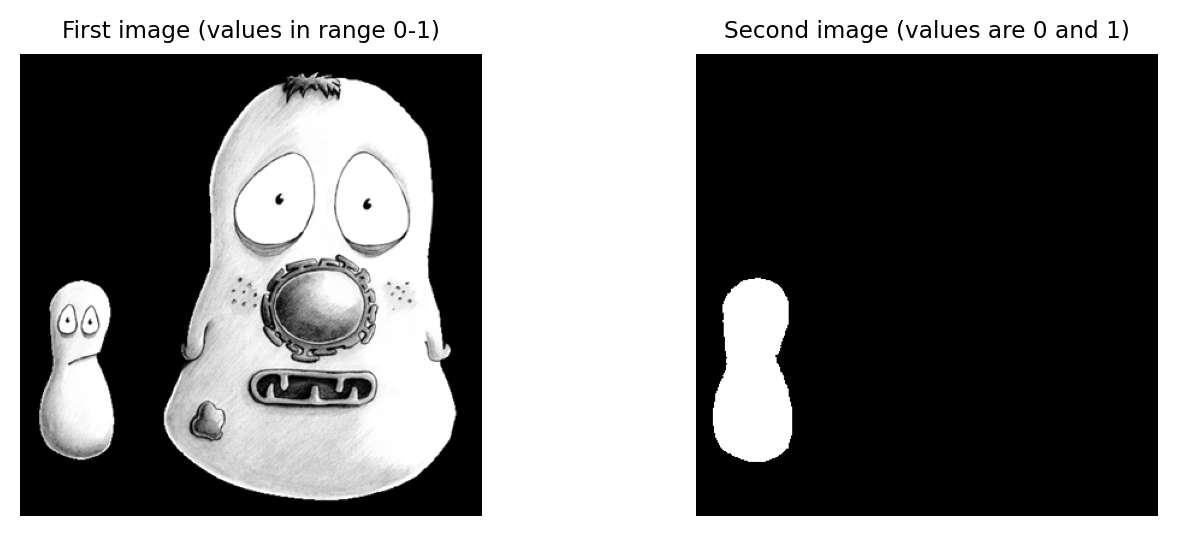

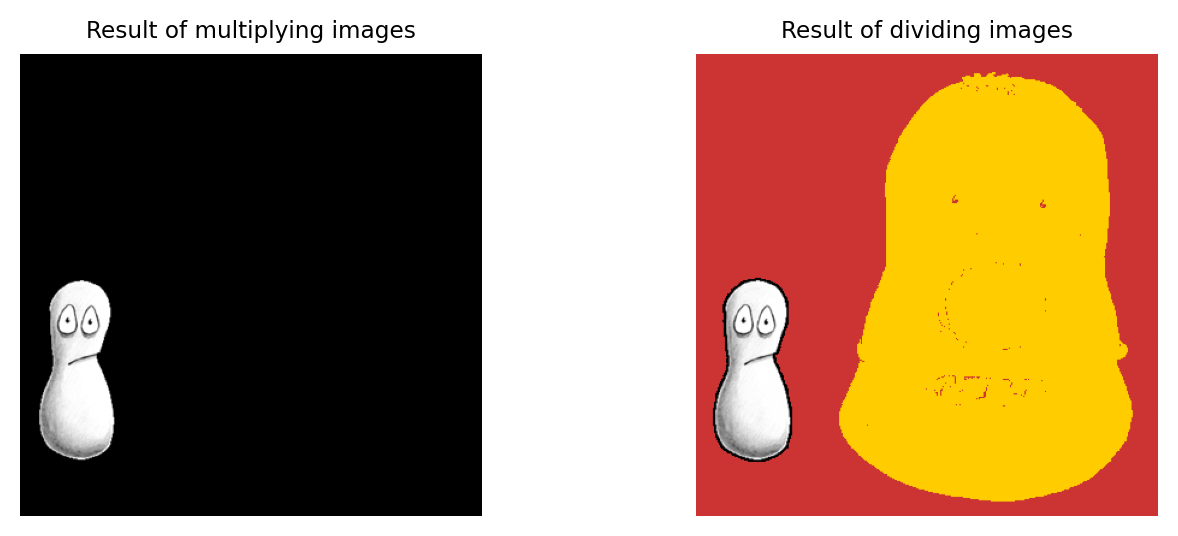

In [5]:
"""
Multiplying an image by a mask.
"""

fig = create_figure(figsize=(8, 3))

im = load_image('images/mask_orig.png').astype(np.float32) / 255
bw_mask = load_image('images/mask_bacteria.png') > 0

# Ensure the image is 2D (and not RGB)
if im.ndim > 2:
    im = im[:, :, 0]

# Plot main image
show_image(im, title="First image (values in range 0-1)", pos=121)

# Plot binary mask
show_image(bw_mask, title="Second image (values are 0 and 1)", pos=122)

glue_fig("fig_points_masking", fig)

# Plot result
fig2 = create_figure(figsize=(8, 3))
show_image(im * bw_mask, title="Result of multiplying images", pos=121)
with np.errstate(divide='ignore', invalid='ignore'):
    im_div = im / bw_mask.astype(np.float32)
    bw_nan = np.isnan(im_div)
    bw_inf = np.isinf(im_div) & (im_div > 0)
    im_div[bw_nan] = 0
    im_div[bw_inf] = 0
    im_div = np.dstack((im_div, im_div, im_div))
    im_div[bw_nan, :] = np.asarray([0.8, 0.2, 0.2]).reshape((1, 1, 3))
    im_div[bw_inf, :] = np.asarray([1, 0.8, 0.0]).reshape((1, 1, 3))
    show_image(im_div, title="Result of dividing images", pos=122)

glue_fig("fig_points_masking_output", fig2)

`````{tab-set}

````{tab-item} Question

In the two 32-bit images shown here, white pixels have values of one and black pixels have values of zero (gray pixels have values somewhere in between).

```{glue:figure} fig_points_masking
---
align: center
---
```

What would be the result of multiplying the images together?
And what would be the result of dividing the left image by the right image?
````

````{tab-item} Answer
Multiplying the images effectively results in everything outside the white region in the right image being removed from the left image (i.e. set to zero).

```{glue:figure} fig_points_masking_output
---
align: center
---
```

Dividing has a similar effect, except that instead of becoming zero the masked-out pixels will take one of three results, depending upon the original pixel's value in the left image:

* if it was _positive_, the result is $+\infty$ (shown here as yellow)
* if it was _negative_, the result is $-\infty$
* if it was zero, the result is `NaN` ('not a number' -– indicating 0/0 is undefined; shown here as red)

These are special values that can be contained in floating point images, but not images with integer types.
````
`````

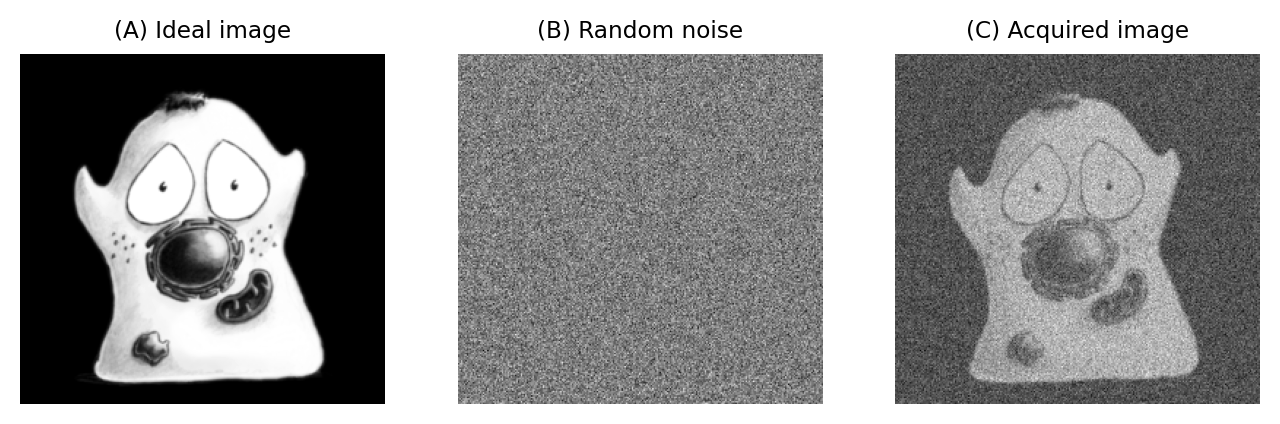

In [6]:
"""
Adding noise to an image.
"""

# Load a sample image, normalize between 0 and 5
im = load_image('happy_cell.tif')
im = im - im.min()
im = im / im.max() * 5

# Create a random number generator - always good to seed this,
# to keep the randomness predictable each time we run the code...
rng = np.random.default_rng(100)

# Create a normally-distributed random value for every pixel
# Mean = 0, Std. dev. 1
im_noise = rng.normal(size=im.shape)

# The image we can acquire has the noise added
im_possible = im + im_noise

# Show images
fig = create_figure(figsize=(8, 4))
show_image(im, title="(A) Ideal image", pos=131)
show_image(im_noise, title="(B) Random noise", pos=132)
show_image(im_possible, title="(C) Acquired image", pos=133)


glue_fig("fig_points_noise_added", fig)

::::{admonition} Adding noise
:class: info

Fluorescence images are invariably noisy.
The noise appears as a graininess throughout the image, which can be seen as arising from a random noise value (positive or negative) being added to every pixel.

This is equivalent to adding a separate 'noise image' to the non-existent cleaner image that we would prefer to have recorded.
If we knew the pixels in the noise image then we could simply subtract it to get the clean result -- but, in practice, their randomness means that we do not.

```{glue:figure} fig_points_noise_added
---
align: center
name: fig-points_noise_added
---

Simulating imperfect image acquisition by adding noise to an 'ideal' image.
```

Despite the fact that noise is undesirable, adding noise images can be extremely useful when developing and validating image analysis methods.

We can use it to create simulations in which the noise behaves statistically just like real noise, and add it to clean images.
Using these simulations we can figure out things like how processing steps or changes during acquisition will affect or reduce the noise, or how sensitive our measurement strategies are to changes in image quality (see {ref}`chap_filters`, {ref}`chap_formation_noise` and {ref}`chap_macro_simulating`).
::::